## IBM Data Science Capstone Jupyter Notebook #1:
### Data Examination and Exploratory Analysis
__Author: Sam Steffes__
<br>*Date: 08/18/2020*

This notebook contains code for part 1 of my Coursera IBM Data Science Capstone project. This project uses data from previous vehicle collisions to try and build a machine learning model that predicts the severity of accidents based on certain features. __This notebook will focus on data examination, initial feature selection and exploratory analysis.__

_The data comes from collision records recorded by the Seattle Police Department from 2004 through May of 2020_

In [1]:
#import some required libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#import the SDOT/SPD dataset on collisions between 2004 and 2020
df_csv = pd.read_csv('Data-collisions.csv')
df_csv.head()

c:\python\python384\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


### 1.0 Data Exploration
We will do some preliminary examination of the dataset to:
 - understand the dataset (incl. the datatypes of different columns)
 - identify possible independent parameters that could be useful for the model
 - identify what data cleansing and pre-processing might be required
 
[Metadata](https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Metadata.pdf)

In [3]:
#what is the size of the dataset
print(df_csv.shape)

#severity code is the target/dependent variable... what is the breakdown of classifications in the dataset?
df_csv.value_counts('SEVERITYCODE')

coll_1 = df_csv[df_csv['SEVERITYCODE']==1].count()['SEVERITYCODE']
coll_2 = df_csv[df_csv['SEVERITYCODE']==2].count()['SEVERITYCODE']
print('Type 1 collisions (property damage) = ', coll_1)
print('Type 2 collisions (with injury) = ', coll_2)
print('Ratio of Collisions with property damage only to those with injuries: '+'{:.2f}'.format(coll_1/coll_2))

(194673, 38)
Type 1 collisions (property damage) =  136485
Type 2 collisions (with injury) =  58188
Ratio of Collisions with property damage only to those with injuries: 2.35


In [4]:
#we can see that the dataset has almost 200k samples and 38 rows.. also there are almost 2.5x the number of
#collisions affecting property as there are collisions with injuries. This makes it an unbalanced dataset

#what are the different columns that exist in the dataset?
df_csv.columns

Index(['SEVERITYCODE', 'X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO',
       'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE',
       'EXCEPTRSNDESC', 'SEVERITYCODE.1', 'SEVERITYDESC', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INCDATE',
       'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC',
       'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC',
       'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR'],
      dtype='object')

After reviewing the columns and metadata, the following look like good candidates for predicting severity (ie they might influence it):

|Column Name|Description|Possible Application/Value/Impact to model|
|:---|:---|:---|
|COLLISIONTYPE|A keyword describing the collision, eg 'head-on', 'angled', 'cycles', etc.|The orientation or nature of the collision could be valuable to the likelihood of injury to people involved.|
|PERSONCOUNT|Total number of people involved in the collision. |More people involved in the collision means more chances for injuries... people could be seated in the vehicle in spots that were closer to the impact, etc.|
|PEDCOUNT|The number of pedestrians involved in the collision.|Pedestrians are at greater risk of injury when struck by vehicles because they are not protected by another vehicle frame, seatbelt, airbag, etc.|
|PEDCYLCOUNT|The number of bicycles involved.|As with pedestrians, bicyclists are also at greater risk of injury when struck by vehicles.|
|VEHCOUNT|The number of vehicles involved in the collision.|More vehicles are more chances for injury, and might suggest more extensive impact, damage or severity.|
|INCDATE/INCDTTM|Date and time recordings for the incident records.|This is not as clear; however, the date or time that an incident occurs may be a proxy for driving behaviours that result in more severe incidents. For example, the are higher traffic volumes during weekday rushhours, and people are in a hurry or distracted.|
|INATTENTIONIND|If collision was due to inattention.|Distracted driving certainly increases the probabibily of getting in an accident, and may affect severity as well.|
|UNDERINFL|If driver was under influence of drugs/alchohol.|Someone under the influence might be driving recklessly, causing the collision to be more severe, and may also not be wearing their seatbelt, increasing their own injury risk.|
|WEATHER|Weather at the time of incident.|Weather could have contributed to the nature of the collision, or the control of the vehicles before and after the collision.|
|ROADCOND|Condition of road at the time of incident.|This is probably closely aligned with weather, but could also capture the maintenance condition of the roadway.|
|LIGHTCOND|Light conditions at the time of incident.|Poor visibility may have contributed to the collision, especially where there are already blind or hidden turns, difficult or dangerous maneuvers are required, or acceptable speeds are already high.|
|SPEEDING|If speeding was a factor in the collision.|Speeding or reckless driving could result in more forceful collisions.|

Lets explore each of the columns.

In [5]:
#first lets look at the two date/time columns for format, samples, etc.

print(df_csv[['INCDATE','INCDTTM']].dtypes)

print(df_csv[['INCDATE','INCDTTM']].describe())

df_csv[['INCDATE','INCDTTM']].head(20)

INCDATE    object
INCDTTM    object
dtype: object
                       INCDATE    INCDTTM
count                   194673     194673
unique                    5985     162058
top     2006/11/02 00:00:00+00  11/2/2006
freq                        96         96


,INCDATE,INCDTTM
0,2013/03/27 00:00:00+00,3/27/2013 2:54:00 PM
1,2006/12/20 00:00:00+00,12/20/2006 6:55:00 PM
2,2004/11/18 00:00:00+00,11/18/2004 10:20:00 AM
3,2013/03/29 00:00:00+00,3/29/2013 9:26:00 AM
4,2004/01/28 00:00:00+00,1/28/2004 8:04:00 AM
5,2019/04/20 00:00:00+00,4/20/2019 5:42:00 PM
6,2008/12/09 00:00:00+00,12/9/2008
7,2020/04/15 00:00:00+00,4/15/2020 5:47:00 PM
8,2006/06/15 00:00:00+00,6/15/2006 1:00:00 PM
9,2006/03/20 00:00:00+00,3/20/2006 3:49:00 PM


In [6]:
#the format for both columns is 'object' and not the datetime type that we would like and there are issues with the timestamp
#this may be and issue, but lets leave for now

#lets look at the volume of incidents overtime... first we need to convert the time to the right format.
#lets use the INCDTTM column since that atleast captures the time for some records
df_csv['DATETIME']=df_csv['INCDTTM'].astype('datetime64[ns]')
print(df_csv['DATETIME'].dtypes)
print(df_csv['DATETIME'].describe())
df_csv[['DATETIME']].head(15)

datetime64[ns]
count                  194673
unique                 162058
top       2006-11-02 00:00:00
freq                       96
first     2004-01-01 00:00:00
last      2020-05-20 00:00:00
Name: DATETIME, dtype: object


<ipython-input-6-19ff1598cd8c>:8: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(df_csv['DATETIME'].describe())


,DATETIME
0,2013-03-27 14:54:00
1,2006-12-20 18:55:00
2,2004-11-18 10:20:00
3,2013-03-29 09:26:00
4,2004-01-28 08:04:00
5,2019-04-20 17:42:00
6,2008-12-09 00:00:00
7,2020-04-15 17:47:00
8,2006-06-15 13:00:00
9,2006-03-20 15:49:00


In [7]:
#group the incidents by year and severity classifiation for plotting
df_annual = df_csv.groupby([df_csv.DATETIME.dt.year,'SEVERITYCODE']).size().unstack(fill_value=0)
df_annual.head()

SEVERITYCODE,1,2
DATETIME,,
2004,8218,3647
2005,10665,4450
2006,10838,4350
2007,10439,4017
2008,9893,3767


In [8]:
#reformat the dataframe
df_annual.reset_index(drop=False,inplace=True)
df_annual.columns = ['Year','Property','Injury']
df_annual.head()

,Year,Property,Injury
0,2004,8218,3647
1,2005,10665,4450
2,2006,10838,4350
3,2007,10439,4017
4,2008,9893,3767


In [9]:
#lets add a Total colum to sum the number of total incidents per year, and calculate the fraction that are severe
df_annual['Total'] = df_annual['Property'] + df_annual['Injury']
df_annual['Severe_rate'] = df_annual['Injury'] / df_annual['Total']
#drop the 2020 row since the year is not complete... we want to look at the recent trend
df_annual.drop(df_annual.tail(1).index,inplace=True)
df_annual.tail()

,Year,Property,Injury,Total,Severe_rate
11,2015,9243,3752,12995,0.288726
12,2016,7945,3714,11659,0.318552
13,2017,7454,3419,10873,0.314449
14,2018,7061,3358,10419,0.322296
15,2019,6350,3062,9412,0.325329


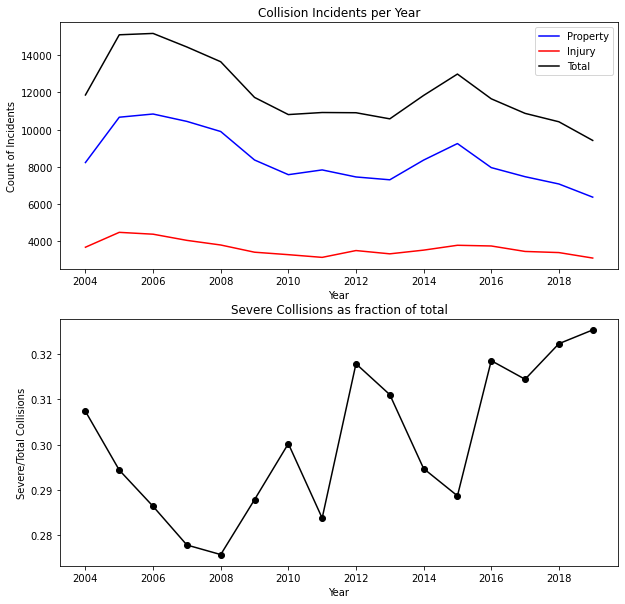

In [10]:
#lets plot the property and injury counts and rate of severe (injury) collisions versus year
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))

ax1.plot('Year','Property',data=df_annual,marker='',color='blue')
ax1.plot('Year','Injury',data=df_annual,marker='',color='red')
ax1.plot('Year','Total',data=df_annual,marker='',color='k')
ax1.set(title='Collision Incidents per Year',xlabel = 'Year',ylabel='Count of Incidents')
ax1.legend()

ax2.plot('Year','Severe_rate',data=df_annual,marker='o',color='k')
ax2.set(title='Severe Collisions as fraction of total',xlabel='Year',ylabel='Severe/Total Collisions')

plt.show()

__This is an interesting observation, and perhaps forms the business case for building a model to predict collision severity.__

In the Spring of 2015, the Seattle Department of Transportation published a 10-year Strategic Vision for sustainable and safe transportation in the city.

[Webpage & Report Link](https://www.seattle.gov/transportation/document-library/citywide-plans/move-seattle)

The report highlights the city's **_Vision Zero_** goal of eliminating serious and fatal crashes by 2030. As we can see from the above chart, while the number of total incidents has decreased every year since 2015, the number of incidents where injuries occur has stayed mostly flat, accounting for a higher percentage of the total volume.

Building a model to predict the severity of collisions could benefit the Seattle DOT in a couple ways:

 - identifying the factors that most contribute to severe collisions, allowing more targetted improvements and changes
 - providing a means to quantify (evaluate) and select improvements options with the most benefit (reduction in severe incidents)
 - allow coordination with emergency response services on resource optimization and development of decision-support tools for dispatching (where response is most critical, etc).

In [11]:
#lets keep exploring the data.. for simplicity, lets create a new df with the features that we want only

df_exp = df_csv[['DATETIME','COLLISIONTYPE','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT','INATTENTIONIND','UNDERINFL',
                'WEATHER','ROADCOND','LIGHTCOND','SPEEDING','SEVERITYCODE']]
print(df_exp.shape)
df_exp.head()

(194673, 13)


,DATETIME,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,SPEEDING,SEVERITYCODE
0,2013-03-27 14:54:00,Angles,2,0,0,2,NaN,N,Overcast,Wet,Daylight,NaN,2
1,2006-12-20 18:55:00,Sideswipe,2,0,0,2,NaN,0,Raining,Wet,Dark - Street Lights On,NaN,1
2,2004-11-18 10:20:00,Parked Car,4,0,0,3,NaN,0,Overcast,Dry,Daylight,NaN,1
3,2013-03-29 09:26:00,Other,3,0,0,3,NaN,N,Clear,Dry,Daylight,NaN,1
4,2004-01-28 08:04:00,Angles,2,0,0,2,NaN,0,Raining,Wet,Daylight,NaN,2


In [12]:
#lets look at collision distribution by the day of the week
df_day = df_exp.groupby([df_exp.DATETIME.dt.dayofweek,'SEVERITYCODE']).size().unstack(fill_value=0)
df_day.reset_index(drop=False,inplace=True)
df_day.columns = ['Weekday','Property','Injury']
df_day['Total'] = df_day['Property'] + df_day['Injury']
df_day['inj_rate'] = df_day['Injury'] / df_day['Total']
df_day

,Weekday,Property,Injury,Total,inj_rate
0,0,18365,7973,26338,0.302719
1,1,19825,8731,28556,0.305750
2,2,20021,8757,28778,0.304295
3,3,20306,9018,29324,0.307530
4,4,22774,9559,32333,0.295642
5,5,19342,8047,27389,0.293804
6,6,15852,6103,21955,0.277978


__(DATETIME) Observation:__ As expected the total volume of collisions is higher for weekdays than weekends. The volumes of total and injury collisions both gradually increase to a peak on Friday before dropping off Saturday and Sunday. The proportion of injury collisions is near identical for Monday-Thursday around 30%. These drop somewhat for Friday - Sunday, but this might be due to the relative changes in volume. <br>
__>>Different days of the week do not have significantly different severity results, therefore this feature will not be used for training.__

Count of total collisions:  194673
Count of collisions on weekdays:  145329
Count of collisions on weekends:  49344


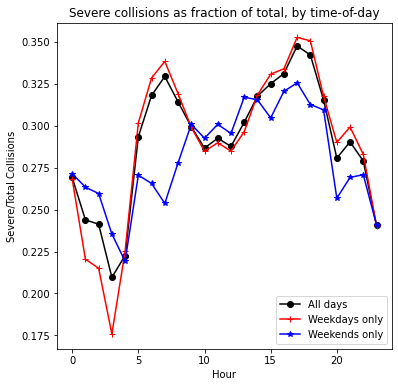

In [13]:
#lets do this same exercise looking at hour of the day
#generate df grouped by hour of day and severity code, for all days of the week
df_hour = df_exp.groupby([df_exp.DATETIME.dt.hour,'SEVERITYCODE']).size().unstack(fill_value=0)
df_hour.reset_index(drop=False,inplace=True)
#reset the column values
df_hour.columns = ['Hour','Property','Injury']
#calculate total sum and proportion of collisions that are severe (involved injury)
df_hour['Total'] = df_hour['Property'] + df_hour['Injury']
df_hour['inj_rate'] = df_hour['Injury'] / df_hour['Total']

#generate an identical grouped dataframe, but including only weekdays - want to see if rush-hour impact stands out more
wkdays = [0,1,2,3,4] #list of values that correspond to Monday-Friday
df_hour2 = df_exp[df_exp.DATETIME.dt.dayofweek.isin(wkdays)].groupby([df_exp.DATETIME.dt.hour,'SEVERITYCODE']).size().unstack(fill_value=0)
df_hour2.reset_index(drop=False,inplace=True)
df_hour2.columns = ['Hour','Property','Injury']
#calculate total and proportion of injury collisions
df_hour2['Total'] = df_hour2['Property'] + df_hour2['Injury']
df_hour2['inj_rate'] = df_hour2['Injury'] / df_hour2['Total']

#generate a third df for only weekend days
df_hour3 = df_exp[~df_exp.DATETIME.dt.dayofweek.isin(wkdays)].groupby([df_exp.DATETIME.dt.hour,'SEVERITYCODE']).size().unstack(fill_value=0)
df_hour3.reset_index(drop=False,inplace=True)
df_hour3.columns = ['Hour','Property','Injury']
df_hour3['Total'] = df_hour3['Property'] + df_hour3['Injury']
df_hour3['inj_rate'] = df_hour3['Injury'] / df_hour3['Total']

#print some relevant counts
print('Count of total collisions: ', df_hour['Total'].sum())
print('Count of collisions on weekdays: ', df_hour2['Total'].sum())
print('Count of collisions on weekends: ', df_hour['Total'].sum() - df_hour2['Total'].sum())

#generate a plot to compare the change in proportion of injury collisions by hour of the day
plt.figure(figsize=(6,6))
#plot rates including all days of the week in black
plt.plot('Hour','inj_rate',data=df_hour,marker='o',color='k')
#plot rates for only weekdays in red
plt.plot('Hour','inj_rate',data=df_hour2,marker='+',color='r')
#plot rates for only weekends in blue
plt.plot('Hour','inj_rate',data=df_hour3,marker='*',color='b')
plt.title('Severe collisions as fraction of total, by time-of-day')
plt.xlabel('Hour')
plt.ylabel('Severe/Total Collisions')
plt.legend(['All days','Weekdays only','Weekends only'],loc=4)
plt.show()

__(DATETIME pt2) Observation:__ here we can see that collisions that occur during the morning and afternoon "rush-hour" periods result in injury more often than at other points in the day. The difference between the Red and Blue lines also shows that this is more pronounced on weekdays vs weekends, further confirming the rushour significance. <br>
To be clear, this is looking at the rate of total collisions that result in injury, not just at the volume (which is likely also high because it is a peak driving time). The time of day is not directly responsible for a collision resulting in injury, but it probably serves as a good proxy for certain driving behaviours or conditions that contribute to both the frequency and severity of collisions. <br>
__>>This is a good feature to use in the model, will simplify by categorizing the time as either rush-hour or non-rush-hour period, rather than full one-hot coding for each hour of the day.__

Text(0, 0.5, 'Severe/Total Collisions')

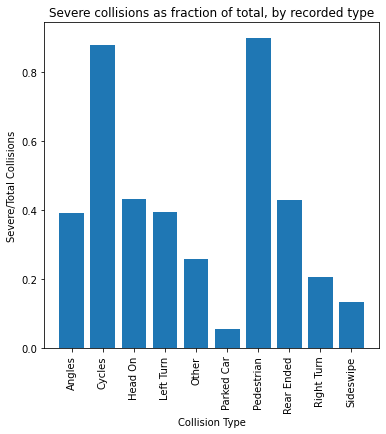

In [14]:
#now lets explore severity versus the different types of collisions that occur
df_type = df_exp.groupby(['COLLISIONTYPE','SEVERITYCODE']).size().unstack(fill_value=0)
df_type.reset_index(drop=False,inplace=True)
df_type.columns = ['Type','Property','Injury']
df_type['Total'] = df_type['Property'] + df_type['Injury']
df_type['inj_rate'] = df_type['Injury'] / df_type['Total']

plt.figure(figsize=(6,6))
plt.bar(df_type['Type'],df_type['inj_rate'])
plt.title('Severe collisions as fraction of total, by recorded type')
plt.xlabel('Collision Type')
plt.xticks(rotation=90)
plt.ylabel('Severe/Total Collisions')

__(COLLISIONTYPE) Observation:__ collisions involving cylces and pedestrians result in injuries in close to 100% of occurences, while those involving parked cars rarely result in injury. This makes sense - pedestrians and bicyclists are not protected by the body of the vehicle and are also likely to have a second impact with the ground after being struck, while collisions with parked cars most probably occur at slower speeds when no one is in the parked car. Angular, head-on, left-turn and rear-end collisions all result in injuries around 40% of the time, while right-turns and sideswips appear to have less severe results. <br>
__>>As we can see substantial differences between the types of collisions, this feature will be used for modelling.__

In [15]:
#lets look at collisions vs PERSONCOUNT (number of people involved)... first lets see the range of different values
df_exp['PERSONCOUNT'].value_counts()

2     114231
3      35553
4      14660
1      13154
5       6584
0       5544
6       2702
7       1131
8        533
9        216
10       128
11        56
12        33
13        21
14        19
15        11
17        11
16         8
44         6
18         6
20         6
25         6
19         5
26         4
22         4
27         3
28         3
29         3
47         3
32         3
34         3
37         3
23         2
21         2
24         2
30         2
36         2
57         1
31         1
35         1
39         1
41         1
43         1
48         1
53         1
54         1
81         1
Name: PERSONCOUNT, dtype: int64

[(-1.0, 11.0)]

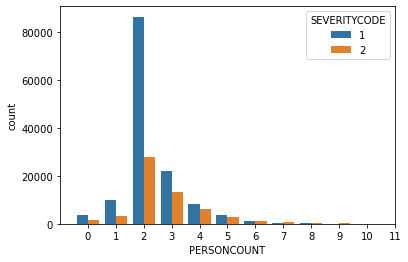

In [16]:
#lets graph the count of property vs injury collisions for the different personcounts
#lets cut the graph off at 11 which is the last count with >50 samples
ax = sns.countplot(x='PERSONCOUNT',hue='SEVERITYCODE',data=df_exp)
ax.set(xlim=(-1,11))

__(PERSONCOUNT) Observations:__ it is unclear what to make of the samples with really high counts of people. Were these incidents incorrectly recorded or did they involved massive pileups, or busses of people? Similarly, there are over 5500 samples where the person count is 0. The majority of cases fall in the range of 1-5 people involved. It is probably best to focus on this area for modeling.

It is not conclusive evidence, but it does appear that for collisions involving 3 or more people, the proportion of property to injury collisions is more evenly split. <br>
__>>First, clean the data to remove samples where the count of people is 0. Then, transform this feature to identify if there are more or less than 3 people involved (1 or 0, respectively) and use it in the model.__

In [17]:
#let apply the same visualization to PEDCOUNT
df_exp['PEDCOUNT'].value_counts()

0    187734
1      6685
2       226
3        22
4         4
6         1
5         1
Name: PEDCOUNT, dtype: int64

[(-1.0, 4.0)]

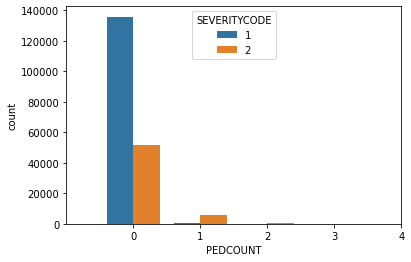

In [18]:
#graph a countplot to see the distribution
ax = sns.countplot(x='PEDCOUNT',hue='SEVERITYCODE',data=df_exp)
ax.set(xlim=(-1,4))

__(PEDCOUNT) Observation:__ this confirms what we saw earlier when studying collision types. It stands to reason that pedestrians struck by vehicles are more likely to withstand injuries than not. <br>
__>>when the pedcount is >1 (at least one pedestrian is involved) injuries are more likely to occur. However, this is already captured by the 'Pedestrian' collision type, which is already in the feature set.__

In [19]:
#bicylce counts..
df_exp['PEDCYLCOUNT'].value_counts()

0    189189
1      5441
2        43
Name: PEDCYLCOUNT, dtype: int64

[(-1.0, 3.0)]

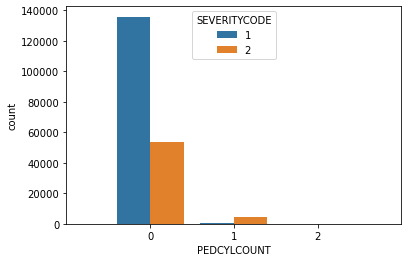

In [20]:
#count plot of severity
ax = sns.countplot(x='PEDCYLCOUNT',hue='SEVERITYCODE',data=df_exp)
ax.set(xlim=(-1,3))

__(CYLCOUNT) Observation:__ as above, this confirms what we expected. When bicycles are involved, injuries are more likely to occur. <br>
__>>The 'Cycles' COLLISIONTYPE already introduces this relationship.__

In [21]:
#vehicle count...
df_exp['VEHCOUNT'].value_counts()

2     147650
1      25748
3      13010
0       5085
4       2426
5        529
6        146
7         46
8         15
9          9
11         6
10         2
12         1
Name: VEHCOUNT, dtype: int64

[(-1.0, 7.0)]

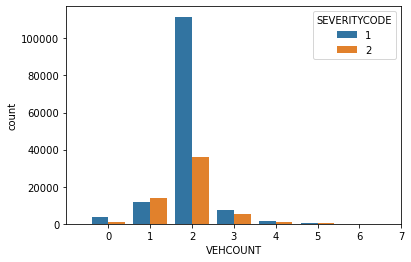

In [22]:
#count plot
ax = sns.countplot(x='VEHCOUNT',hue='SEVERITYCODE',data=df_exp)
ax.set(xlim=(-1,7))

__(VEHCOUNT) Observation:__ Collisions involving one vehicle have resulted in more incidents with injury than property damange only. One hypothesis might be that collisions involving one vehicle disproportionately include those involving pedestrians or bicycles, which result in injury more often, as we have already seen.

In [23]:
#what does the distribution of collision types show for those involving only 1 vehicle?
df_exp[df_exp['VEHCOUNT']==1].groupby(['COLLISIONTYPE','SEVERITYCODE']).size().unstack(fill_value=0)

SEVERITYCODE,1,2
COLLISIONTYPE,,
Angles,3,24
Cycles,660,4479
Head On,1,1
Left Turn,2,16
Other,10298,3688
Parked Car,10,5
Pedestrian,664,5868
Rear Ended,1,1
Right Turn,0,3


__(VEHCOUNT pt2) Observation:__ indeed, we see that the 'Cycles' and 'Pedestrian' types make up a large percentage of incidents involving one vehicle, and these overwhelmingly fall in the injury classification (severity = 2). A visual review of the original dataset shows that the 'Other' collision type commonly involves cars hitting objects in the road or fixed objects on the side of the road. <br>
__>>Collisions involving 2 vehicles are most common and therefore align to the property/injury proportion; collisions with 1 vehicle have high injury classification rate, but are often represented by ped/bike incidents which are already represented by the COLLISIONTYPE. Still overall, injuries seem to be more common when the vehicle count is something other than 2. Lets create a feature representing whether the collision has 2 vehicles or not (0,1).__

In [24]:
#now lets look at the some of the features that capture possible driver distractions, starting with inattentiveness
df_exp['INATTENTIONIND'].value_counts()

Y    29805
Name: INATTENTIONIND, dtype: int64

In [25]:
#we can see from the value counts ouput that there are a bunch of records that are not accounted for
#this is likely because they are empty (blank).. lets assume that blank means 'No' and adjust the data
df_exp['INATTENTIONIND'].fillna('N',inplace=True)
df_exp['INATTENTIONIND'].value_counts()

c:\python\python384\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


N    164868
Y     29805
Name: INATTENTIONIND, dtype: int64

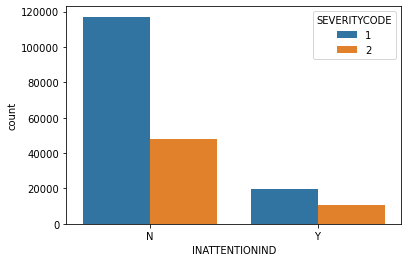

In [26]:
#look at the severity distribution
ax = sns.countplot(x='INATTENTIONIND',hue='SEVERITYCODE',data=df_exp)

In [27]:
df_attn = df_exp.groupby(['INATTENTIONIND','SEVERITYCODE']).size().unstack(fill_value=0)
df_attn.reset_index(drop=False,inplace=True)
df_attn.columns = ['State','Property','Injury']
df_attn['Total'] = df_attn['Property'] + df_attn['Injury']
print('Rate of Injury for inattentive collisions (Y): '+'{:.2f}'.format(df_attn.loc[0,'Injury']/df_attn.loc[0,'Total']))
print('Rate of Injury for attentive collisions (N): '+'{:.2f}'.format(df_attn.loc[1,'Injury']/df_attn.loc[1,'Total']))
df_attn

Rate of Injury for inattentive collisions (Y): 0.29
Rate of Injury for attentive collisions (N): 0.35


,State,Property,Injury,Total
0,N,117077,47791,164868
1,Y,19408,10397,29805


__(INATTENTIONIND) Observation:__ collisions due to inattentive driving are slightly more likely to result in injuries than those where inattentiveness is not an issue; however, neither are more likely to result in injury than not. <br>
__>>Injuries occur in a higher percentage of collisions where inattentive driving is present, so lets use this as a feature.__

In [28]:
#what about driving under the influence?
df_exp['UNDERINFL'].value_counts()

N    100274
0     80394
Y      5126
1      3995
Name: UNDERINFL, dtype: int64

__(UNDERINFL) Observation:__ there will be some cleansing required here if we use this feature for the model... it is assumed that N and 0 both reflect that drugs/alcohol were __not__ involved, while Y and 1 mean they were present. There are also 4884 records missing, which must be blank. Since in a marjority of cases alcohol/drug influence was positively or negatively identified, lets not assume that the blank records are one or the other. These only represent 2.5% of the dataset, so we could drop these before modelling.

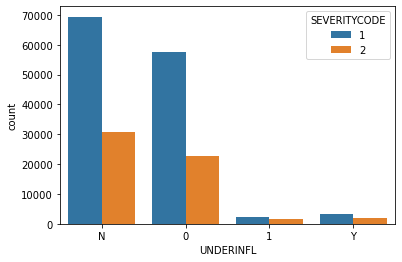

In [29]:
#lets observe the value counts for influenced driving
ax = sns.countplot(x='UNDERINFL',hue='SEVERITYCODE',data=df_exp)

In [30]:
df_infl = df_exp.groupby(['UNDERINFL','SEVERITYCODE']).size().unstack(fill_value=0)
df_infl.reset_index(drop=False,inplace=True)
df_infl.columns = ['State','Property','Injury']
df_infl['Total'] = df_infl['Property'] + df_infl['Injury']
print('Rate of Injury for influenced collisions (Y, 1): '+'{:.2f}'.format(
    (df_infl.loc[1,'Injury']+df_infl.loc[3,'Injury'])/(df_infl.loc[1,'Total']+df_infl.loc[3,'Total'])))
print('Rate of Injury for sober collisions (N, 0): '+'{:.2f}'.format(
    (df_infl.loc[0,'Injury']+df_infl.loc[2,'Injury'])/(df_infl.loc[0,'Total']+df_infl.loc[2,'Total'])))

Rate of Injury for influenced collisions (Y, 1): 0.39
Rate of Injury for sober collisions (N, 0): 0.30


__(UNDERINFL pt2) Observation:__ collisions where drugs or alcohol were involved resulted in injury at a higher rate than collisions where no drugs or alcohol were involved. <br>
__>>Lets include this as a feature.__

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'Overcast'),
  Text(1, 0, 'Raining'),
  Text(2, 0, 'Clear'),
  Text(3, 0, 'Unknown'),
  Text(4, 0, 'Other'),
  Text(5, 0, 'Snowing'),
  Text(6, 0, 'Fog/Smog/Smoke'),
  Text(7, 0, 'Sleet/Hail/Freezing Rain'),
  Text(8, 0, 'Blowing Sand/Dirt'),
  Text(9, 0, 'Severe Crosswind'),
  Text(10, 0, 'Partly Cloudy')])

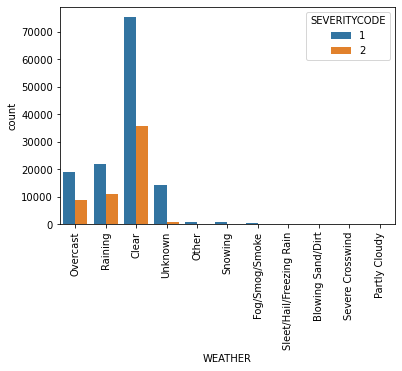

In [31]:
#lets look at the impact of weather
ax=sns.countplot(x='WEATHER',hue='SEVERITYCODE',data=df_exp)
plt.xticks(rotation=90)

In [32]:
#there is very low volume for the last half-dozen weather types in chart above. lets look at the actual counts
df_wea = df_exp.groupby(['WEATHER','SEVERITYCODE']).size().unstack(fill_value=0)
df_wea.reset_index(drop=False,inplace=True)
df_wea.columns = ['Weather','Property','Injury']
df_wea['Total'] = df_wea['Property'] + df_wea['Injury']
df_wea['inj_rate'] = df_wea['Injury'] / df_wea['Total']
df_wea

,Weather,Property,Injury,Total,inj_rate
0,Blowing Sand/Dirt,41,15,56,0.267857
1,Clear,75295,35840,111135,0.322491
2,Fog/Smog/Smoke,382,187,569,0.328647
3,Other,716,116,832,0.139423
4,Overcast,18969,8745,27714,0.315544
5,Partly Cloudy,2,3,5,0.600000
6,Raining,21969,11176,33145,0.337185
7,Severe Crosswind,18,7,25,0.280000
8,Sleet/Hail/Freezing Rain,85,28,113,0.247788
9,Snowing,736,171,907,0.188534


__(WEATHER) Observation:__ rainy weather does increase the rate of injury accidents, but only slightly compared to clear conditions. Some of the other inclement weather types actually have lower injury rates than expected. This might be because people tend to avoid driving during poor weather (therefore lower overall counts) or drive more cautiously (therefore lower rate of injury)? Lets manipulate the data to look at simplified groupings...

In [33]:
#create a dictionary of weather keys with assigned values: inclement weather types = 1, unknown/other = 2, etc..
w_dict = {'Clear':0,'Partly Cloudy':0,'Overcast':0,'Blowing Sand/Dirt':1,'Fog/Smog/Smoke':1,'Raining':1,
         'Severe Crosswind':1,'Sleet/Hail/Freezing Rain':1,'Snowing':1,'Other':2,'Unknown':2}
#extract just the weather and severity columns for this investigation
df_weather = df_exp[['WEATHER','SEVERITYCODE']]
#replace the blank values in the WEATHER column and then drop them
df_weather['WEATHER'].replace(r'^\s*$',np.NaN,regex=True)
df_weather.dropna(axis=0,subset=['WEATHER'],inplace=True)
#replace the values in the WEATHER column with the associated values for the keys in the weather dictionary
df_weather.WEATHER = [w_dict[item] for item in df_weather.WEATHER]
#create a new dataframe to group the output by these new weather categories (0,1,2)
df_wea2 = df_weather.groupby(['WEATHER','SEVERITYCODE']).size().unstack(fill_value=0)
df_wea2.reset_index(drop=False,inplace=True)
df_wea2.columns = ['Weather','Property','Injury']
df_wea2['Total'] = df_wea2['Property'] + df_wea2['Injury']
df_wea2['inj_rate'] = df_wea2['Injury'] / df_wea2['Total']
df_wea2

<ipython-input-33-3b501dce6926>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather.dropna(axis=0,subset=['WEATHER'],inplace=True)
c:\python\python384\lib\site-packages\pandas\core\generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,Weather,Property,Injury,Total,inj_rate
0,0,94266,44588,138854,0.321114
1,1,23231,11584,34815,0.332730
2,2,14991,932,15923,0.058532


__(WEATHER pt2) Observations:__ after removing the samples with no recorded weather, and grouping everything as either clear/cloudy ('0'), inclement ('1') or unknown/other ('2') we can see that there is only a slight difference between how often injuries occur between the different weather conditions. <br>
__>>Weather is not a good feature and will not be included__

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Wet'),
  Text(1, 0, 'Dry'),
  Text(2, 0, 'Unknown'),
  Text(3, 0, 'Snow/Slush'),
  Text(4, 0, 'Ice'),
  Text(5, 0, 'Other'),
  Text(6, 0, 'Sand/Mud/Dirt'),
  Text(7, 0, 'Standing Water'),
  Text(8, 0, 'Oil')])

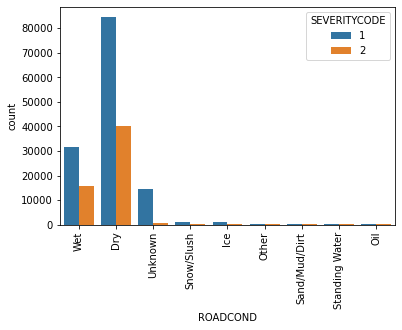

In [34]:
#let look at the results for different road conditions
ax = sns.countplot(x='ROADCOND',hue='SEVERITYCODE',data=df_exp)
plt.xticks(rotation=90)

In [35]:
#calculate the rates for each condition
df_cond = df_exp.groupby(['ROADCOND','SEVERITYCODE']).size().unstack(fill_value=0)
df_cond.reset_index(drop=False,inplace=True)
df_cond.columns = ['Condition','Property','Injury']
df_cond['Total'] = df_cond['Property'] + df_cond['Injury']
df_cond['inj_rate'] = df_cond['Injury'] / df_cond['Total']
df_cond

,Condition,Property,Injury,Total,inj_rate
0,Dry,84446,40064,124510,0.321773
1,Ice,936,273,1209,0.225806
2,Oil,40,24,64,0.375000
3,Other,89,43,132,0.325758
4,Sand/Mud/Dirt,52,23,75,0.306667
5,Snow/Slush,837,167,1004,0.166335
6,Standing Water,85,30,115,0.260870
7,Unknown,14329,749,15078,0.049675
8,Wet,31719,15755,47474,0.331866


__Observation:__ injury collision rates are different for dry versus other conditions, however they are not consistently higher as might be expected, ie it is higher for Oil and Wet conditions (only slightly), but less for Snow, Ice and other categories. There are also very low sample volumes for most of these other conditions, so there isn't substantial evidence. For the two highest classifications - dry and wet - the injury rates are not remarkably different. <br>
__>>ROADCOND will not be used as a feature__

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Daylight'),
  Text(1, 0, 'Dark - Street Lights On'),
  Text(2, 0, 'Dark - No Street Lights'),
  Text(3, 0, 'Unknown'),
  Text(4, 0, 'Dusk'),
  Text(5, 0, 'Dawn'),
  Text(6, 0, 'Dark - Street Lights Off'),
  Text(7, 0, 'Other'),
  Text(8, 0, 'Dark - Unknown Lighting')])

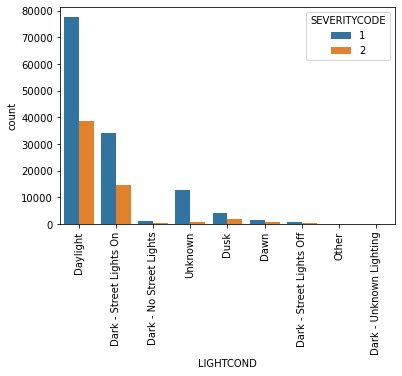

In [36]:
#what about light conditions
ax = sns.countplot(x='LIGHTCOND',hue='SEVERITYCODE',data=df_exp)
plt.xticks(rotation=90)

In [37]:
#calculat the rate of injury collision for each type of lighting
df_lite = df_exp.groupby(['LIGHTCOND','SEVERITYCODE']).size().unstack(fill_value=0)
df_lite.reset_index(drop=False,inplace=True)
df_lite.columns = ['Condition','Property','Injury']
df_lite['Total'] = df_lite['Property'] + df_lite['Injury']
df_lite['inj_rate'] = df_lite['Injury'] / df_lite['Total']
df_lite

,Condition,Property,Injury,Total,inj_rate
0,Dark - No Street Lights,1203,334,1537,0.217306
1,Dark - Street Lights Off,883,316,1199,0.263553
2,Dark - Street Lights On,34032,14475,48507,0.298411
3,Dark - Unknown Lighting,7,4,11,0.363636
4,Dawn,1678,824,2502,0.329337
5,Daylight,77593,38544,116137,0.331884
6,Dusk,3958,1944,5902,0.329380
7,Other,183,52,235,0.221277
8,Unknown,12868,605,13473,0.044905


__(LIGHTCOND) Observations:__ again there is nothing remarkable about dark or poor lighting conditions versus daylight. At best this feature might have been a good proxy for different expected outcomes for day driving versus night driving. It is more likely however, that the total volume and severity outcomes are lower during darker conditions because there is less volume (traffic) during those times. <br>
__>>LIGHTCOND will not be used as a feature__

In [38]:
#lastly lets look at the outcomes for collisions where speeding is involved
df_exp['SPEEDING'].value_counts()

Y    9333
Name: SPEEDING, dtype: int64

In [39]:
#similar to the INATTENTIONIND feature, we have missing samples due to blank values. lets assume that blank means 'No'
df_exp['SPEEDING'].fillna('N',inplace=True)
df_exp['SPEEDING'].value_counts()

c:\python\python384\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


N    185340
Y      9333
Name: SPEEDING, dtype: int64

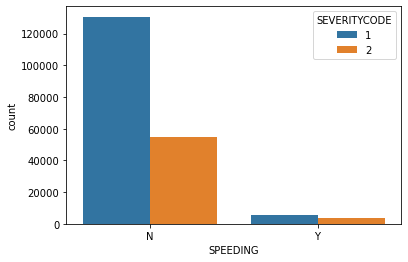

In [40]:
#and now the severity distribution
ax = sns.countplot(x='SPEEDING',hue='SEVERITYCODE',data=df_exp)

In [41]:
#calculate the injury collision rates speeding vs no speeding samples
df_speed = df_exp.groupby(['SPEEDING','SEVERITYCODE']).size().unstack(fill_value=0)
df_speed.reset_index(drop=False,inplace=True)
df_speed.columns = ['Speeding','Property','Injury']
df_speed['Total'] = df_speed['Property'] + df_speed['Injury']
df_speed['inj_rate'] = df_speed['Injury'] / df_speed['Total']
df_speed

,Speeding,Property,Injury,Total,inj_rate
0,N,130683,54657,185340,0.294901
1,Y,5802,3531,9333,0.378335


__(SPEEDING) Observation:__ we can see that the proportion of collisions resulting in injury is 1.28 times higher when speeding is involved compared to when speeding is not involved. <br>
__>>SPEEDING will be selected as a feature__

### Summary:

 - this notebook has explored the impact of certain features on collision severity (proportion of injury collisions)
 - time of day (weekday rushhour), type of collision, # of people and vehicles, inattentiveness, drugs and alcohol, and speeding show noticeable differences between the possible states, and appear to be good candidates for training the model
 - pedestrian and bicycle count showed obvious associations with injury rate, but these would make redundant features because collision type already captures these scenarios
 - meanwhile, contrary to expectation, Weather, Road and Light conditions didnt show remarkable patterns with respect to the rate of injury in collisions
 
The following link is for the next Jupyter Notebook, which will:

 - summarize feature selection,
 - cleanse and prepare the data,
 - train, test and evaluate several machine learning models
 


In [42]:
#lets export the dataframe with explore features, so we can start there in the next notebook
#we are doing this at the end, because we have made some manipulations (fillna for both INATTENTIONIND and SPEEDING)
df_exp.to_csv('explored_features.csv', index=False)